# Train classification

Most sharing code train this dataset as a regression task.

But in this code, I train as a classification task.

I encode the target value pressure to 950 classes and calculate CrossEntropy Loss.

In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>")) 

In [2]:
import gc
import os
import sys
import copy
import random
import wandb
import math
from pathlib import Path
from collections import OrderedDict

import numpy as np
import pandas as pd
import scipy.signal
from scipy import signal

from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW
from transformers import get_cosine_schedule_with_warmup
from sklearn.preprocessing import RobustScaler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

device = torch.device("cuda")

In [3]:
sys.path.append('../../src/')
import utils as utils
from utils import Timer

In [4]:
class CFG:
    exp_num = 87
    n_folds = 5
    folds = [0]
    seed = 777
    local = True
    
    lr = 0.0015
    epochs = 80
    emb_dim = 64
    hidden_dim = 256
    weight_decay = 0.1  
    
    ######################
    # Loaders #
    ######################
    loader_params = {
        "train": {
            'batch_size': 128,
            'shuffle': True,
            'num_workers': 8,
            'pin_memory': True,
            'drop_last': True,
        },
        "valid": {
            'batch_size': 32,
            'shuffle': False,
            'num_workers': 8,
            'pin_memory': True,
            'drop_last': False,
        },
        "test": {
            'batch_size': 32,
            'shuffle': False,
            'num_workers': 8,
            'pin_memory': True,
            'drop_last': False,
        }
    }


In [5]:
utils.set_seed(CFG.seed)    

In [6]:
if CFG.local:
    DATA_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/ventilator-pressure-prediction")
    OUTPUT_DIR = Path('./output/')
else:
    DATA_DIR = Path("../input/ventilator-pressure-prediction")
    OUTPUT_DIR = Path('')   

In [7]:
# def loss_fn(y_pred, y_true, u_outs):
# #     loss = nn.L1Loss()(y_pred.reshape(-1), y_true.reshape(-1))
#     w = 1 - u_outs.reshape(-1)
#     loss = nn.CrossEntropyLoss(reduction = 'none')(y_pred.reshape(-1, 950), y_true.reshape(-1)).reshape(-1)
#     loss = loss * w
#     loss = loss.sum() / w.sum()
#     return loss

class CustomLoss(nn.Module):
    def __init__(self, unique_targets, target_dic_inv):
        super().__init__()

        self.criterion = nn.CrossEntropyLoss(reduction = 'none')
        self.unique_targets = unique_targets
        self.target_dic_inv = target_dic_inv
        
    def forward(self, y_pred, y_true, u_outs, y_true_raw, ratio):
        
        ## classification
        loss = self.criterion(y_pred.reshape(-1, 950), y_true.reshape(-1)).reshape(-1)
        
        for lag, w in [(1, 0.4), (2, 0.2), (3, 0.1), (4, 0.1)]:
            # negative lag loss
            # if target < 0, target = 0
            neg_lag_target = F.relu(y_true.reshape(-1) - lag)
            neg_lag_target = neg_lag_target.long()
            neg_lag_loss = self.criterion(y_pred.reshape(-1, 950), neg_lag_target.reshape(-1)).reshape(-1)

            # positive lag loss
            # if target > 949, target = 949
            pos_lag_target = 949 - F.relu((949 - (y_true.reshape(-1) + lag)))
            pos_lag_target = pos_lag_target.long()
            pos_lag_loss = self.criterion(y_pred.reshape(-1, 950), pos_lag_target.reshape(-1)).reshape(-1)

            loss += (neg_lag_loss + pos_lag_loss) * w
        
        ## regression
        pred = y_pred.reshape(-1, 950).softmax(1)
        pred = torch.sum(torch.tensor(self.unique_targets).to(device) *  pred, axis=1).reshape(-1)
        target = y_true_raw.reshape(-1)
#         loss_mae = (target - pred).abs()
#         loss += loss_mae / 2
        loss *= ratio
        smooth_l1 = nn.functional.smooth_l1_loss(input=pred, target=target, reduction='none', beta=0.1)
        loss += smooth_l1 /2
        
        w_u = 1 - u_outs.reshape(-1)
        loss = loss * w_u
        loss = loss.sum() / w_u.sum()

        return loss, pred, target

def compute_metric(preds, trues, u_outs):
    """
    Metric for the problem, as I understood it.
    """
    
    y = trues
    w = 1 - u_outs
    
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    
    return mae

def get_score(y_pred, y_true, u_outs):
    return compute_metric(y_pred, y_true, u_outs)

In [8]:
class VentilatorDataset(Dataset):
    
    def __init__(self, df, train_value_col, train_category_col, label_dic=None):
        self.dfs = [_df for _, _df in df.groupby("breath_id")]
        self.label_dic = label_dic
        
    def __len__(self):
        return len(self.dfs)
    
    def __getitem__(self, item):
        df = self.dfs[item]
        X = df[train_category_col + train_value_col].values
        u_out = df['u_out'].values
        y = df['pressure'].values
        if self.label_dic is None:
            label = [-1]
        else:
            label = [self.label_dic[i] for i in y]

        d = {
            "X": torch.tensor(X).float(),
            "u_out": torch.tensor(u_out).long(),
            "y" : torch.tensor(label).long(),
            "y_raw" : torch.tensor(y).float(),
        }
        return d

In [9]:
class VentilatorModel(nn.Module):
    
    def __init__(self, input_dim):
        super(VentilatorModel, self).__init__()
        self.rc_emb = nn.Embedding(9, 4, padding_idx=0)

        self.seq_emb = nn.Sequential(
            nn.Linear(4+input_dim, CFG.emb_dim),
            nn.LayerNorm(CFG.emb_dim)
        )
        
        self.lstm1 = nn.LSTM(CFG.emb_dim, 400, batch_first=True, bidirectional=True, dropout=0.1)
        self.lstm2 = nn.LSTM(2*400, 300, batch_first=True, bidirectional=True, dropout=0.1)
        self.lstm3 = nn.LSTM(2*300, 200, batch_first=True, bidirectional=True, dropout=0.1)
        self.lstm4 = nn.LSTM(2*200, CFG.hidden_dim, batch_first=True, bidirectional=True, dropout=0.1)

        self.ln1 = nn.LayerNorm(CFG.hidden_dim * 2)
        self.head = nn.Sequential(
            nn.Linear(CFG.hidden_dim * 2, CFG.hidden_dim * 2),
            nn.LayerNorm(CFG.hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(CFG.hidden_dim * 2, 950),
        )
        
        # Encoder
        initrange = 0.1
        self.rc_emb.weight.data.uniform_(-initrange, initrange)
        
        # LSTM
        for n, m in self.named_modules():
            if isinstance(m, nn.LSTM):
#                 nn.init.xavier_uniform_(m.weight_ih_l0)
#                 nn.init.orthogonal_(m.weight_hh_l0)
#                 nn.init.xavier_uniform_(m.weight_ih_l0_reverse)
#                 nn.init.orthogonal_(m.weight_hh_l0_reverse)
#             if isinstance(m, nn.LSTM):
                print(f'init {m}')
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)
                        


    def forward(self, X, y=None):
        # embed
        bs = X.shape[0]
        rc_emb = self.rc_emb(X[:,:,0].long()).view(bs, 80, -1)

        seq_x = torch.cat((rc_emb, X[:, :, 1:]), 2)
        emb_x = self.seq_emb(seq_x)
        
        emb_x, _ = self.lstm1(emb_x)
        emb_x, _ = self.lstm2(emb_x)
        emb_x, _ = self.lstm3(emb_x)
        out, _ = self.lstm4(emb_x)
        out = self.ln1(out)
        logits = self.head(out)

        return logits

In [10]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, num_train_steps, num_warmup_steps, target_dic_inv, unique_targets):
        super().__init__()
        self.model = model
        self.criterion = CustomLoss(unique_targets, target_dic_inv)
        self.num_train_steps = num_train_steps
        self.num_warmup_steps = num_warmup_steps
        self.target_dic_inv = target_dic_inv
        self.unique_targets = unique_targets
        self.last_epoch = CFG.epochs - 1
    
    def training_step(self, batch, batch_idx):
        d_ = batch
        out = self.model(d_['X'])
        loss, _, _ = self.criterion(out, d_['y'], d_['u_out'], d_['y_raw'], (self.current_epoch!=self.last_epoch)*1)
        
        self.log(f'Loss/train', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        sch = self.lr_schedulers()
        sch.step()
        return loss
    
    def validation_step(self, batch, batch_idx):
        d_ = batch
        out = self.model(d_['X'])
        loss, pred, target = self.criterion(out, d_['y'], d_['u_out'], d_['y_raw'], (self.current_epoch!=self.last_epoch)*1)
        
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        
        output = OrderedDict({
            "targets": target.detach(), "preds": pred.detach(), "u_outs": d_['u_out'].detach(), "loss": loss.detach()
        })
        return output
    
    def validation_epoch_end(self, outputs):

        targets = torch.cat([o["targets"].view(-1) for o in outputs]).cpu().numpy()
        preds = torch.cat([o["preds"].view(-1) for o in outputs]).cpu().numpy()
        u_outs = torch.cat([o["u_outs"].view(-1) for o in outputs]).cpu().numpy()

        score = get_score(preds, targets, u_outs)
        self.log(f'custom_mae/val', score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        print(f'epoch = {self.current_epoch}, custom_mae = {score}')

    def configure_optimizers(self):
#         optimizer = get_optimizer(self.model)
#         scheduler = get_scheduler(optimizer)
        optimizer = AdamW(self.model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
        scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=self.num_warmup_steps, 
                                                    num_training_steps=self.num_train_steps)

        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [11]:
def valid_loop(model, loader, target_dic_inv):
    predicts = []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out = model(d['X'].to(device))
        pred = out.reshape(-1, 950).softmax(1)
        pred = torch.sum(torch.tensor(unique_targets).to(device) *  pred, axis=1)
        predicts.append(pred.cpu().numpy())

    return np.concatenate(predicts)

def test_loop(model, loader, target_dic_inv):
    predicts = []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out = model(d['X'].to(device))
        pred = out.reshape(-1, 950).softmax(1)
        pred = torch.sum(torch.tensor(unique_targets).to(device) *  pred, axis=1)
        predicts.append(pred.cpu().numpy())

    return np.concatenate(predicts)

In [12]:
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')
sub_df = pd.read_csv(DATA_DIR / "sample_submission.csv")

In [13]:
train['R_C'] = train['R'].astype(str) + '_' + train['C'].astype(str)
train['num'] = train.groupby(['breath_id', 'R_C']).cumcount()

test['R_C'] = test['R'].astype(str) + '_' + test['C'].astype(str)
test['num'] = test.groupby(['breath_id', 'R_C']).cumcount()

In [14]:
display(train), display(test)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,R_C,num
0,1,1,20,50,0.000000,0.083334,0,5.837492,20_50,0
1,2,1,20,50,0.033652,18.383041,0,5.907794,20_50,1
2,3,1,20,50,0.067514,22.509278,0,7.876254,20_50,2
3,4,1,20,50,0.101542,22.808822,0,11.742872,20_50,3
4,5,1,20,50,0.135756,25.355850,0,12.234987,20_50,4
...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032,50_10,75
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032,50_10,76
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729,50_10,77
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938,50_10,78


,id,breath_id,R,C,time_step,u_in,u_out,R_C,num
0,1,0,5,20,0.000000,0.000000,0,5_20,0
1,2,0,5,20,0.031904,7.515046,0,5_20,1
2,3,0,5,20,0.063827,14.651675,0,5_20,2
3,4,0,5,20,0.095751,21.230610,0,5_20,3
4,5,0,5,20,0.127644,26.320956,0,5_20,4
...,...,...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1,20_10,75
4023996,4023997,125748,20,10,2.563853,4.975709,1,20_10,76
4023997,4023998,125748,20,10,2.597475,4.979468,1,20_10,77
4023998,4023999,125748,20,10,2.631134,4.982648,1,20_10,78


(None, None)

In [31]:
def get_raw_features(input_df, dataType = 'train'):
    colum = ['time_step', 'u_in', 'u_out']
    
    u_in_table = pd.pivot_table(train, index=['breath_id', 'R_C'], columns='num', values='u_in')
    u_in_table = u_in_table.add_prefix('u_in_')

    return u_in_table.reset_index()

In [32]:
train_df = get_raw_features(train)

In [33]:
train_df

num,breath_id,R_C,u_in_0,u_in_1,u_in_2,u_in_3,u_in_4,u_in_5,u_in_6,u_in_7,...,u_in_70,u_in_71,u_in_72,u_in_73,u_in_74,u_in_75,u_in_76,u_in_77,u_in_78,u_in_79
0,1,20_50,0.083334,18.383041,22.509278,22.808822,25.355850,27.259866,27.127486,26.807732,...,4.940237,4.949604,4.957466,4.964136,4.969730,4.974474,4.978481,4.981847,4.984683,4.987079
1,2,20_20,12.184338,13.980205,12.574163,11.730537,12.124229,11.055636,10.774428,11.111878,...,4.946820,4.955128,4.962164,4.968085,4.973087,4.977307,4.980860,4.983857,4.986382,4.988518
2,3,50_20,0.000000,7.187242,13.338781,17.111335,18.353980,17.417672,15.353111,13.641899,...,4.876171,4.894445,4.910021,4.923308,4.934620,4.944269,4.952485,4.959494,4.965451,4.970562
3,4,50_50,0.000000,1.262539,4.001352,6.379411,8.295194,9.790410,10.874443,13.336506,...,4.879581,4.897809,4.912832,4.925605,4.936515,4.946119,4.954007,4.960767,4.966532,4.971585
4,5,5_50,21.424375,28.504653,29.353025,30.502095,31.024647,32.224651,32.364788,32.858346,...,4.954280,4.961622,4.967670,4.972735,4.977117,4.980725,4.983751,4.986374,4.988504,4.990306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75445,125740,50_50,0.000000,0.000000,0.673913,1.700763,2.619867,3.397223,4.030364,4.540090,...,4.951377,4.958965,4.965437,4.970984,4.975529,4.979396,4.982703,4.985436,4.987730,4.989706
75446,125742,20_10,85.630231,100.000000,81.566813,0.000000,23.328401,89.819686,0.000000,0.000000,...,4.937050,4.946832,4.955088,4.962065,4.967939,4.972923,4.977126,4.980671,4.983671,4.986201
75447,125743,20_10,0.000000,0.000000,0.000000,0.950177,3.256712,4.678061,4.628657,4.970097,...,4.935777,4.945808,4.954189,4.961282,4.967358,4.972427,4.976734,4.980354,4.983397,4.985969
75448,125745,50_50,15.564236,23.588836,20.298696,12.326433,10.807906,11.630441,10.997722,9.542468,...,4.877733,4.895692,4.911043,4.924128,4.935280,4.944776,4.952874,4.959785,4.965696,4.970727


In [35]:
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df['R_C'])):
    trn_df = train_df.loc[train_idx]
    val_df = train_df.loc[valid_idx]
    break

In [157]:
trn_df20_50 = train_df.reset_index(drop=True)
val_df20_50 = train_df.reset_index(drop=True)

In [158]:
val_df20_50.iloc[:, 3:]

num,u_in_1,u_in_2,u_in_3,u_in_4,u_in_5,u_in_6,u_in_7,u_in_8,u_in_9,u_in_10,...,u_in_70,u_in_71,u_in_72,u_in_73,u_in_74,u_in_75,u_in_76,u_in_77,u_in_78,u_in_79
0,18.383041,22.509278,22.808822,25.355850,27.259866,27.127486,26.807732,27.864715,28.313036,26.866758,...,4.940237,4.949604,4.957466,4.964136,4.969730,4.974474,4.978481,4.981847,4.984683,4.987079
1,13.980205,12.574163,11.730537,12.124229,11.055636,10.774428,11.111878,10.099527,10.043285,9.424626,...,4.946820,4.955128,4.962164,4.968085,4.973087,4.977307,4.980860,4.983857,4.986382,4.988518
2,7.187242,13.338781,17.111335,18.353980,17.417672,15.353111,13.641899,12.336795,11.487085,11.166449,...,4.876171,4.894445,4.910021,4.923308,4.934620,4.944269,4.952485,4.959494,4.965451,4.970562
3,1.262539,4.001352,6.379411,8.295194,9.790410,10.874443,13.336506,15.998234,18.294006,20.196161,...,4.879581,4.897809,4.912832,4.925605,4.936515,4.946119,4.954007,4.960767,4.966532,4.971585
4,28.504653,29.353025,30.502095,31.024647,32.224651,32.364788,32.858346,32.551761,34.031274,32.964679,...,4.954280,4.961622,4.967670,4.972735,4.977117,4.980725,4.983751,4.986374,4.988504,4.990306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75445,0.000000,0.673913,1.700763,2.619867,3.397223,4.030364,4.540090,4.827675,5.123065,5.396925,...,4.951377,4.958965,4.965437,4.970984,4.975529,4.979396,4.982703,4.985436,4.987730,4.989706
75446,100.000000,81.566813,0.000000,23.328401,89.819686,0.000000,0.000000,60.719625,19.595675,0.000000,...,4.937050,4.946832,4.955088,4.962065,4.967939,4.972923,4.977126,4.980671,4.983671,4.986201
75447,0.000000,0.000000,0.950177,3.256712,4.678061,4.628657,4.970097,5.302141,4.236358,3.840883,...,4.935777,4.945808,4.954189,4.961282,4.967358,4.972427,4.976734,4.980354,4.983397,4.985969
75448,23.588836,20.298696,12.326433,10.807906,11.630441,10.997722,9.542468,10.934450,10.997722,9.542468,...,4.877733,4.895692,4.911043,4.924128,4.935280,4.944776,4.952874,4.959785,4.965696,4.970727


In [159]:
nn = NearestNeighbors(n_neighbors=500, metric="l1", n_jobs=-1)

In [160]:
nbrs = nn.fit(trn_df20_50.iloc[:, 2:].values)

In [162]:
distances, indices = nbrs.kneighbors(val_df20_50.iloc[:2, 2:].values)

In [166]:
neighbor_b_ids = trn_df20_50.iloc[indices[1].argsort()[:1], :]['breath_id'].values

In [167]:
import matplotlib.pyplot as plt


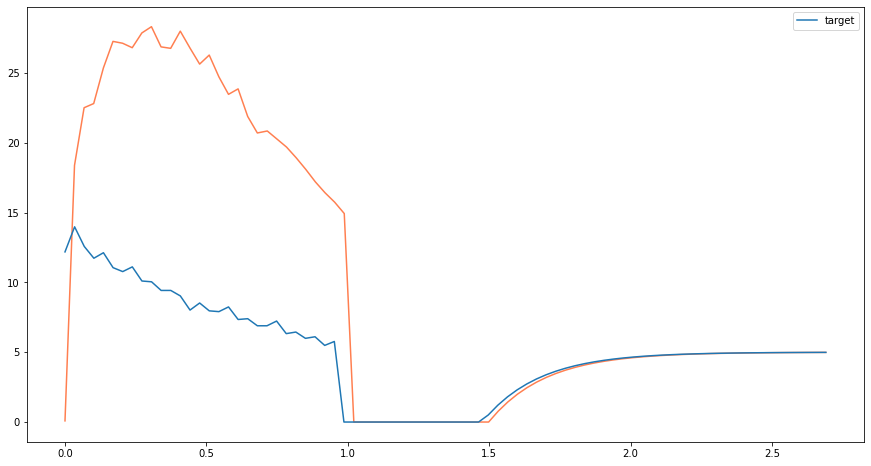

In [168]:
plt.figure(figsize=(15, 8))
for breath_id in neighbor_b_ids:
    tmp_df = train[train['breath_id'] == breath_id].reset_index(drop=True)

#     plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], color='coral')
#     plt.scatter(tmp_df['time_step'][peaks], tmp_df['u_in'][peaks], c='red')
#     plt.set_title(f'R: {R}, C: {C}, breath_id: {breath_id}, score: {score}')
#     plt.legend()
tmp_df = train[train['breath_id'] == 2].reset_index(drop=True)
plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='target')
plt.legend()

In [15]:
def get_category_features(input_df, dataType = 'train'):
    output_df = copy.deepcopy(input_df)
    colum = ['R_C']
    rc_map = {'5_10': 0, '5_20': 1, '5_50': 2, '20_10': 3, '20_20': 4, '20_50': 5, '50_10': 6, '50_20': 7, '50_50': 8}
    
    output_df['R_C'] = [f'{r}_{c}' for r, c in zip(output_df['R'], output_df['C'])]
    output_df['R_C'] = output_df['R_C'].map(rc_map)

    return output_df[colum]

In [16]:
def get_simple_calc_features(input_df, dataType = 'train'):
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    output_df['time_delta'] = output_df.groupby('breath_id')['time_step'].diff().fillna(0)
    output_df['delta'] = output_df['time_delta'] * output_df['u_in']
    output_df['area'] = output_df.groupby('breath_id')['delta'].cumsum()

    output_df['cross']= output_df['u_in']*output_df['u_out']
    output_df['cross2']= output_df['time_step']*output_df['u_out']
    
    output_df['u_in_cumsum'] = (output_df['u_in']).groupby(output_df['breath_id']).cumsum()
    output_df['one'] = 1
    output_df['count'] = (output_df['one']).groupby(output_df['breath_id']).cumsum()
    output_df['u_in_cummean'] =output_df['u_in_cumsum'] / output_df['count']
    
    output_df['u_in_sqrt'] = output_df['u_in'].apply(lambda x: np.sqrt(x))
    output_df['u_in_sqrt_cumsum'] = output_df.groupby('breath_id')['u_in_sqrt'].cumsum()
    
    output_df = output_df.drop(['count','one'], axis=1)
    
    return output_df.iloc[:, c_num:]

In [17]:
def get_agg_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    # Dict for aggregations
    create_feature_dict = {
        'u_in': [np.max, np.mean],
    }
    
    def get_agg_window(start_time=0, end_time=3.0, add_suffix = False):
        
        df_tgt = output_df[(output_df['time_step'] >= start_time) & (output_df['time_step'] <= end_time)]
        df_feature = df_tgt.groupby(['breath_id']).agg(create_feature_dict)
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(start_time) + '_' + str(end_time))
            
        return df_feature
    
    df_agg_feature = get_agg_window().reset_index()
    
#     df_tmp = get_agg_window(start_time = 2, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(start_time = 1, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(end_time = 1, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(end_time = 2, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')

    output_df = pd.merge(output_df, df_agg_feature, how='left', on='breath_id')
    
    output_df['u_in_diffmax'] = output_df['u_in_amax'] - output_df['u_in']
    output_df['u_in_diffmean'] = output_df['u_in_mean'] - output_df['u_in']
    
#     output_df = output_df.drop(['u_in_amax','u_in_mean'], axis=1)
    
    return output_df.iloc[:, c_num:]

In [18]:
def get_half_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    output_df['tmp'] = output_df['u_out']*(-1)+1 # inversion of u_out
    output_df['u_in_half'] = output_df['tmp'] * output_df['u_in']
    
#     u_in_half_max_dict = train.groupby('breath_id')['u_in_half'].max().to_dict()
#     train['u_in_half_max'] = train['breath_id'].map(u_in_half_max_dict)
#     u_in_half_min_dict = train.groupby('breath_id')['u_in_half'].min().to_dict()
#     train['u_in_half_min'] = train['breath_id'].map(u_in_half_min_dict)
    u_in_half_mean_dict = output_df.groupby('breath_id')['u_in_half'].mean().to_dict()
    output_df['u_in_half_mean'] = output_df['breath_id'].map(u_in_half_mean_dict)
#     u_in_half_std_dict = train.groupby('breath_id')['u_in_half'].std().to_dict()
#     train['u_in_half_std'] = train['breath_id'].map(u_in_half_std_dict)

    del output_df['u_in_half'], output_df['tmp']
    return output_df.iloc[:, c_num:]

In [19]:
def lowpass_filter(series, b, a):
    return signal.filtfilt(b, a, series)    

In [20]:
def get_filter_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    fp = 5 # 通過域端周波数[Hz]
    fs = 10 # 阻止域端周波数[Hz]
    gpass = 3 # 通過域端最大損失[dB]
    gstop = 40 # 阻止域端最小損失[dB]
    samplerate = 100

    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    
    def get_agg_window(start_time=0, end_time=3.0, add_suffix = False):
        
        df_tgt = output_df[(output_df['time_step'] >= start_time) & (output_df['time_step'] <= end_time)]
        df_feature = df_tgt.groupby(['breath_id'])['u_in'].apply(lowpass_filter, b=b, a=a)
        df_feature.name = 'u_in_filter'
                    
        return df_feature
    
    df_agg_feature = get_agg_window().reset_index()
    df_agg_feature = df_agg_feature.explode("u_in_filter").reset_index(drop=True)
    df_agg_feature['u_in_filter'] = df_agg_feature['u_in_filter'].astype(float)
        
    df_agg_feature['u_in_filter_cumsum'] = df_agg_feature.groupby('breath_id')['u_in_filter'].cumsum()

    return df_agg_feature.iloc[:, 1:]

In [21]:
def get_vib_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    output_df['u_out_diff'] = output_df['u_out'].diff()
    output_df['u_out_diff'].fillna(0, inplace=True)
    output_df['u_out_diff'].replace(-1, 0, inplace=True)
    uout1_df = output_df[output_df['u_out_diff']==1]
    
    first_df = output_df.loc[0::80,:]
    first_0_dict = dict(zip(first_df['id'], [0]*len(uout1_df)))

    output_df['u_in_diff'] = output_df['u_in'].diff()
    output_df['diff_sign'] = np.sign(output_df['u_in_diff'])
    output_df['sign_diff'] = output_df['diff_sign'].diff()
    output_df['tmp'] = output_df['id'].map(first_0_dict) # put 0, the 80row cycle
    output_df.iloc[0::80, output_df.columns.get_loc('sign_diff')] = output_df.iloc[0::80, output_df.columns.get_loc('tmp')]

    # Count the number of inversions, so take the absolute value and sum
    output_df['sign_diff'] = abs(output_df['sign_diff']) 
    sign_diff_dict = output_df.groupby('breath_id')['sign_diff'].sum().to_dict()
    output_df['diff_vib'] = output_df['breath_id'].map(sign_diff_dict)
    
    return output_df['sign_diff']

In [22]:
def add_time_features(out_df, input_df, dataType = 'train'):

    USE_LAG = [-2, -1, 1, 2, 3, 4]
    lag_map = {-2: 1, -1: 2, 1: 3, 2: 4, 3: 5, 4: 6}

    out_df['breath_id'] = input_df['breath_id']
    
    for lag in USE_LAG:
        out_df[f'breath_id_lag{lag_map[lag]}']=out_df['breath_id'].shift(lag).fillna(0)
        out_df[f'breath_id_lag{lag_map[lag]}same']=np.select([out_df[f'breath_id_lag{lag_map[lag]}']==out_df['breath_id']], [1], 0)

        # u_in_filter
        out_df[f'u_in_filter_lag_{lag_map[lag]}'] = out_df['u_in_filter'].shift(lag).fillna(0) * out_df[f'breath_id_lag{lag_map[lag]}same']
        out_df[f'u_in_filter_diff_{lag_map[lag]}'] = out_df['u_in_filter'] - out_df[f'u_in_filter_lag_{lag_map[lag]}']
        # u_in_sqrt
        out_df[f'u_in_sqrt_lag_{lag_map[lag]}'] = out_df['u_in_sqrt'].shift(lag).fillna(0) * out_df[f'breath_id_lag{lag_map[lag]}same']
        out_df[f'u_in_sqrt_diff_{lag_map[lag]}'] = out_df['u_in_sqrt'] - out_df[f'u_in_sqrt_lag_{lag_map[lag]}']

        # u_in 
        out_df[f'u_in_lag_{lag_map[lag]}'] = out_df['u_in'].shift(lag).fillna(0) * out_df[f'breath_id_lag{lag_map[lag]}same']
        out_df[f'u_in_diff_{lag_map[lag]}'] = out_df['u_in'] - out_df[f'u_in_lag_{lag_map[lag]}']
        # u_out
        out_df[f'u_out_lag_{lag_map[lag]}'] = out_df['u_out'].shift(lag).fillna(0) * out_df[f'breath_id_lag{lag_map[lag]}same']

        # breath_time
        out_df[f'time_step_lag_{lag_map[lag]}'] = out_df['time_step'].shift(lag).fillna(0) * out_df[f'breath_id_lag{lag_map[lag]}same']
        out_df[f'time_step_diff_{lag_map[lag]}'] = out_df['time_step'] - out_df[f'time_step_lag_{lag_map[lag]}']
        
        # gap
        out_df[f'u_in_rate_{lag_map[lag]}'] = out_df[f'u_in_diff_{lag_map[lag]}'] / out_df[f'time_step_diff_{lag_map[lag]}']
        out_df[f'u_in_rate_{lag_map[lag]}'] = out_df[f'u_in_rate_{lag_map[lag]}'].replace(np.inf, 0)
        
    drop_columns = ['breath_id']
    drop_columns += [f'breath_id_lag{lag_map[i]}' for i in USE_LAG]
    drop_columns += [f'breath_id_lag{lag_map[i]}same' for i in USE_LAG]
    out_df = out_df.drop(drop_columns, axis=1)
    out_df = out_df.fillna(0)
    
    return out_df

In [23]:
def to_feature(input_df, dataType = 'train'):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        get_raw_features,
        get_simple_calc_features,
        get_agg_features,
        get_vib_features,
#         get_half_features,
        get_category_features,
        get_filter_features,
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='' + func.__name__ + ' '):
            _df = func(input_df, dataType)

        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
#     out_df = utils.reduce_mem_usage(out_df)
    out_df = add_time_features(out_df, input_df)
    out_df_cols = sorted(list(out_df))
    out_df = out_df[out_df_cols]
    
    return out_df

In [24]:
train_df = to_feature(train, dataType = 'train')
test_df = to_feature(test, dataType = 'test')

  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.021[s]
get_simple_calc_features  16.230[s]
get_agg_features  1.042[s]
get_vib_features  0.491[s]
get_category_features  2.286[s]
get_filter_features  11.237[s]


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.015[s]
get_simple_calc_features  10.687[s]
get_agg_features  0.624[s]
get_vib_features  0.313[s]
get_category_features  1.467[s]
get_filter_features  7.338[s]


In [25]:
train_category_col = ['R_C']
train_value_col = [i for i in train_df.columns.to_list() if i not in train_category_col]

In [26]:
norm_features = train_value_col
norm_features = sorted(list(set(train_value_col) - set(['u_out'])), key=norm_features.index)
def norm_scale(train_df, test_df):
    scaler = RobustScaler()
    all_u_in = np.vstack([train_df[norm_features].values, test_df[norm_features].values])
    scaler.fit(all_u_in)
    train_df[norm_features] = scaler.transform(train_df[norm_features].values)
    test_df[norm_features] = scaler.transform(test_df[norm_features].values)
    return train_df, test_df

In [27]:
train_df, test_df = norm_scale(train_df, test_df)

In [28]:
train_df = utils.reduce_mem_usage(train_df)
test_df = utils.reduce_mem_usage(test_df)

Mem. usage decreased from 3684.08 Mb to 909.51 Mb (75.3% reduction)
Mem. usage decreased from 2456.05 Mb to 606.34 Mb (75.3% reduction)


In [29]:
train_df = pd.concat([train_df, train[['id', 'breath_id', 'pressure']]], axis=1)
test_df = pd.concat([test_df, test[['id', 'breath_id']]], axis=1)
test_df['pressure'] = train_df['pressure'].values[-1]

In [30]:
unique_targets = sorted(train_df['pressure'].unique().tolist())
target_dic = {v:i for i, v in enumerate(sorted(train_df['pressure'].unique().tolist()))}
target_dic_inv = {v: k for k, v in target_dic.items()}

In [31]:
display(train_df), display(test_df)

,R_C,area,cross,cross2,delta,sign_diff,time_delta,time_step,time_step_diff_1,time_step_diff_2,...,u_out,u_out_lag_1,u_out_lag_2,u_out_lag_3,u_out_lag_4,u_out_lag_5,u_out_lag_6,id,breath_id,pressure
0,5,-0.734375,0.000000,-0.665527,-0.861328,0.0,-15.476562,-0.989258,-0.163574,-0.104309,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,5.837492
1,5,-0.682617,0.000000,-0.665527,2.867188,0.0,0.104309,-0.963867,-0.250977,-0.201538,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2,1,5.907794
2,5,-0.619141,0.000000,-0.665527,3.732422,0.0,0.201538,-0.937988,-0.332520,-0.278320,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,1,7.876254
3,5,-0.554688,0.000000,-0.665527,3.816406,0.0,0.278320,-0.912109,-0.312744,-0.364258,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,1,11.742872
4,5,-0.482666,0.000000,-0.665527,4.367188,0.0,0.364258,-0.886230,-0.265381,-0.238647,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5,1,12.234987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6,0.322998,0.333008,0.608887,-0.561523,0.0,-0.007175,0.904785,0.001553,0.032135,...,1,0.0,0.0,0.0,0.0,0.0,0.0,6035996,125749,3.869032
6035996,6,0.327148,0.332764,0.625977,-0.562012,2.0,-0.032135,0.930176,0.006378,-0.009163,...,1,0.0,0.0,0.0,0.0,0.0,0.0,6035997,125749,3.869032
6035997,6,0.331543,0.348389,0.642578,-0.546875,2.0,0.009163,0.955078,0.046814,0.041748,...,1,0.0,0.0,0.0,0.0,0.0,0.0,6035998,125749,3.798729
6035998,6,0.334961,0.284424,0.659668,-0.605469,2.0,-0.041748,0.980469,621.500000,0.071350,...,1,-1.0,0.0,0.0,0.0,0.0,0.0,6035999,125749,4.079938


,R_C,area,cross,cross2,delta,sign_diff,time_delta,time_step,time_step_diff_1,time_step_diff_2,...,u_out,u_out_lag_1,u_out_lag_2,u_out_lag_3,u_out_lag_4,u_out_lag_5,u_out_lag_6,id,breath_id,pressure
0,1,-0.734375,0.000000,-0.665527,-0.861328,0.0,-15.476562,-0.989258,0.693848,0.705566,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,3.869032
1,1,-0.714355,0.000000,-0.665527,0.583984,0.0,-0.705566,-0.964844,0.689453,0.696289,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2,0,3.869032
2,1,-0.675293,0.000000,-0.665527,1.958008,0.0,-0.696289,-0.940918,0.696777,0.696289,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,0,3.869032
3,1,-0.619141,0.000000,-0.665527,3.224609,0.0,-0.696289,-0.916504,0.698730,0.710449,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,0,3.869032
4,1,-0.549316,0.000000,-0.665527,4.199219,0.0,-0.710449,-0.892578,0.693848,0.700684,...,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5,0,3.869032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,3,-0.216797,1.111328,0.621582,0.150024,0.0,0.151123,0.923828,-0.127319,-0.143188,...,1,0.0,0.0,0.0,0.0,0.0,0.0,4023996,125748,3.869032
4023996,3,-0.202881,1.112305,0.639160,0.150513,0.0,0.143188,0.949707,-0.109253,-0.090332,...,1,0.0,0.0,0.0,0.0,0.0,0.0,4023997,125748,3.869032
4023997,3,-0.188843,1.113281,0.656250,0.147827,0.0,0.090332,0.975098,-0.236084,-0.107300,...,1,0.0,0.0,0.0,0.0,0.0,0.0,4023998,125748,3.869032
4023998,3,-0.174927,1.114258,0.673340,0.149536,0.0,0.107300,1.000000,627.500000,-0.342773,...,1,-1.0,0.0,0.0,0.0,0.0,0.0,4023999,125748,3.869032


(None, None)

In [32]:
oof = np.zeros(len(train_df))
test_preds_lst = []
input_dim = len(train_value_col)
train_df['pred'] = 0
train_gby = train_df.groupby('breath_id')['R_C'].agg('first').reset_index()
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    
for fold, (_, valid_idx) in enumerate(skf.split(train_gby, train_gby['R_C'])):        
    valid_b_ids = train_gby.iloc[valid_idx]['breath_id'].values
    valid_df_idx = train_df[train_df['breath_id'].isin(valid_b_ids)].index.to_list()
    train_df.loc[valid_df_idx, 'fold'] = fold

for i, fold in enumerate(range(CFG.n_folds)):
    if i not in CFG.folds:
        continue
    print(f'Fold-{fold}')
    
    trn_df = train_df.query(f"fold!={fold}").reset_index(drop=True)
    val_df = train_df.query(f"fold=={fold}").reset_index(drop=True)
    
    loaders = {
        phase: DataLoader(
            VentilatorDataset(
                df_, train_value_col, train_category_col, target_dic
            ),
            **CFG.loader_params[phase])  # type: ignore
        for phase, df_ in zip(["train", "valid", "test"], [trn_df, val_df, test_df])
    }
    

    model = VentilatorModel(input_dim)
    model_name = model.__class__.__name__
    

    num_train_steps = int(len(loaders['train']) * CFG.epochs)
    num_warmup_steps = int(num_train_steps / 10)
    learner = Learner(model, num_train_steps, num_warmup_steps, target_dic_inv, unique_targets)
    
    # loggers
    RUN_NAME = f'exp{str(CFG.exp_num)}'
    wandb.init(project='Ventilator-Pressure-Prediction', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{i}')
    wandb.run.name = RUN_NAME + f'-fold-{i}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'custom_mae/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        save_weights_only=True,
        filename=f'{model_name}-{CFG.exp_num}-{learner.current_epoch}-{i}')
    callbacks.append(checkpoint_callback)
    
    loggers = []
    loggers.append(WandbLogger())
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=CFG.epochs,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
#         fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=False,
        )
    
    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])
#     trainer.save_checkpoint(OUTPUT_DIR / "last.ckpt")
    print('train done.')

    ############
    # validation (to make oof)
    #############
    checkpoint = torch.load(checkpoint_callback.best_model_path)
    learner.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    
    valid_predict = valid_loop(model, loaders['valid'], target_dic_inv)
    valid_score_mask = compute_metric(valid_predict, val_df['pressure'].values, val_df['u_out'].values)
    print(f"fold = {fold}, valid mask score = {valid_score_mask}:")
    train_df.loc[train_df['fold'] == fold, 'pred'] = valid_predict
    train_df.loc[train_df['fold'] == fold, ['id', 'pred']].to_csv(OUTPUT_DIR / f"oof_f{fold}_{CFG.exp_num}.csv", index=None)
    
    #############
    # inference
    #############

    test_preds = test_loop(model, loaders['test'], target_dic_inv)
    test_preds_lst.append(test_preds)
    
    sub_df['pressure'] = test_preds
    sub_df.to_csv(OUTPUT_DIR / f"sub_f{fold}_{CFG.exp_num}.csv", index=None)
    
wandb.finish()

Fold-0


/home/user/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


init LSTM(64, 400, batch_first=True, dropout=0.1, bidirectional=True)
init LSTM(800, 300, batch_first=True, dropout=0.1, bidirectional=True)
init LSTM(600, 200, batch_first=True, dropout=0.1, bidirectional=True)
init LSTM(400, 256, batch_first=True, dropout=0.1, bidirectional=True)


wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | VentilatorModel | 7.5 M 
1 | criterion | CustomLoss      | 0     
----------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
30.098    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, custom_mae = 13.988754365335422


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, custom_mae = 2.8446064036137995


Validating: 0it [00:00, ?it/s]

epoch = 1, custom_mae = 1.428929167401684


Validating: 0it [00:00, ?it/s]

epoch = 2, custom_mae = 1.0050108619591316


Validating: 0it [00:00, ?it/s]

epoch = 3, custom_mae = 0.7198922100273265


Validating: 0it [00:00, ?it/s]

epoch = 4, custom_mae = 0.6443731007052091


Validating: 0it [00:00, ?it/s]

epoch = 5, custom_mae = 0.5904171145998559


Validating: 0it [00:00, ?it/s]

epoch = 6, custom_mae = 0.5036548055543505


Validating: 0it [00:00, ?it/s]

epoch = 7, custom_mae = 0.59587912098666


Validating: 0it [00:00, ?it/s]

epoch = 8, custom_mae = 0.9772238591298336


Validating: 0it [00:00, ?it/s]

epoch = 9, custom_mae = 0.523086208668565


Validating: 0it [00:00, ?it/s]

epoch = 10, custom_mae = 0.4721720756538351


Validating: 0it [00:00, ?it/s]

epoch = 11, custom_mae = 0.4006055895204802


Validating: 0it [00:00, ?it/s]

epoch = 12, custom_mae = 0.40380349285677536


Validating: 0it [00:00, ?it/s]

epoch = 13, custom_mae = 0.46007649697710457


Validating: 0it [00:00, ?it/s]

epoch = 14, custom_mae = 0.34335196673871515


Validating: 0it [00:00, ?it/s]

epoch = 15, custom_mae = 0.33561673018213983


Validating: 0it [00:00, ?it/s]

epoch = 16, custom_mae = 0.3365372219629253


Validating: 0it [00:00, ?it/s]

epoch = 17, custom_mae = 0.3154969329703977


Validating: 0it [00:00, ?it/s]

epoch = 18, custom_mae = 0.3091576837820902


Validating: 0it [00:00, ?it/s]

epoch = 19, custom_mae = 0.2899677126481858


Validating: 0it [00:00, ?it/s]

epoch = 20, custom_mae = 0.3118597206649862


Validating: 0it [00:00, ?it/s]

epoch = 21, custom_mae = 0.3258731347433196


Validating: 0it [00:00, ?it/s]

epoch = 22, custom_mae = 0.2897790678606251


Validating: 0it [00:00, ?it/s]

epoch = 23, custom_mae = 0.36410227126864275


Validating: 0it [00:00, ?it/s]

epoch = 24, custom_mae = 0.26421497541051997


Validating: 0it [00:00, ?it/s]

epoch = 25, custom_mae = 0.29743750097396765


Validating: 0it [00:00, ?it/s]

epoch = 26, custom_mae = 0.7806814078913751


Validating: 0it [00:00, ?it/s]

epoch = 27, custom_mae = 0.27709350664044413


Validating: 0it [00:00, ?it/s]

epoch = 28, custom_mae = 0.2726399262556482


Validating: 0it [00:00, ?it/s]

epoch = 29, custom_mae = 0.3347983564815633


Validating: 0it [00:00, ?it/s]

epoch = 30, custom_mae = 0.26310204931807246


Validating: 0it [00:00, ?it/s]

epoch = 31, custom_mae = 0.2827732227795455


Validating: 0it [00:00, ?it/s]

epoch = 32, custom_mae = 0.22923458951262496


Validating: 0it [00:00, ?it/s]

epoch = 33, custom_mae = 0.2586137482648632


Validating: 0it [00:00, ?it/s]

epoch = 34, custom_mae = 0.24855013661373052


Validating: 0it [00:00, ?it/s]

epoch = 35, custom_mae = 0.2875783949707314


Validating: 0it [00:00, ?it/s]

epoch = 36, custom_mae = 0.22915330923963645


Validating: 0it [00:00, ?it/s]

epoch = 37, custom_mae = 0.23422381729568448


Validating: 0it [00:00, ?it/s]

epoch = 38, custom_mae = 0.22565348810378935


Validating: 0it [00:00, ?it/s]

epoch = 39, custom_mae = 0.24308472788230584


Validating: 0it [00:00, ?it/s]

epoch = 40, custom_mae = 0.2289271620234865


Validating: 0it [00:00, ?it/s]

epoch = 41, custom_mae = 0.20994995327176144


Validating: 0it [00:00, ?it/s]

epoch = 42, custom_mae = 0.28525423324330457


Validating: 0it [00:00, ?it/s]

epoch = 43, custom_mae = 0.24140393440762598


Validating: 0it [00:00, ?it/s]

epoch = 44, custom_mae = 0.2224861064717094


Validating: 0it [00:00, ?it/s]

epoch = 45, custom_mae = 0.19833365518686502


Validating: 0it [00:00, ?it/s]

epoch = 46, custom_mae = 0.20204769543462275


Validating: 0it [00:00, ?it/s]

epoch = 47, custom_mae = 0.19432595322829743


Validating: 0it [00:00, ?it/s]

epoch = 48, custom_mae = 0.20854044915479017


Validating: 0it [00:00, ?it/s]

epoch = 49, custom_mae = 0.1956748712464057


Validating: 0it [00:00, ?it/s]

epoch = 50, custom_mae = 0.1928221860702602


Validating: 0it [00:00, ?it/s]

epoch = 51, custom_mae = 0.18582498623636587


Validating: 0it [00:00, ?it/s]

epoch = 52, custom_mae = 0.18373918184764787


Validating: 0it [00:00, ?it/s]

epoch = 53, custom_mae = 0.17925312564244225


Validating: 0it [00:00, ?it/s]

epoch = 54, custom_mae = 0.18102098659052657


Validating: 0it [00:00, ?it/s]

epoch = 55, custom_mae = 0.17339029768407282


Validating: 0it [00:00, ?it/s]

epoch = 56, custom_mae = 0.17895164355053


Validating: 0it [00:00, ?it/s]

epoch = 57, custom_mae = 0.16669702075827467


Validating: 0it [00:00, ?it/s]

epoch = 58, custom_mae = 0.1676517639562322


Validating: 0it [00:00, ?it/s]

epoch = 59, custom_mae = 0.16326222843054503


Validating: 0it [00:00, ?it/s]

epoch = 60, custom_mae = 0.1623338117810585


Validating: 0it [00:00, ?it/s]

epoch = 61, custom_mae = 0.16346827755192772


Validating: 0it [00:00, ?it/s]

epoch = 62, custom_mae = 0.15788918678696126


Validating: 0it [00:00, ?it/s]

epoch = 63, custom_mae = 0.15841717486389284


Validating: 0it [00:00, ?it/s]

epoch = 64, custom_mae = 0.15908164778411532


Validating: 0it [00:00, ?it/s]

epoch = 65, custom_mae = 0.15531288428335496


Validating: 0it [00:00, ?it/s]

epoch = 66, custom_mae = 0.1517778210672665


Validating: 0it [00:00, ?it/s]

epoch = 67, custom_mae = 0.1502469189986059


Validating: 0it [00:00, ?it/s]

epoch = 68, custom_mae = 0.1515682297990232


Validating: 0it [00:00, ?it/s]

epoch = 69, custom_mae = 0.14969497562172132


Validating: 0it [00:00, ?it/s]

epoch = 70, custom_mae = 0.14868276747471612


Validating: 0it [00:00, ?it/s]

epoch = 71, custom_mae = 0.14797622113946926


Validating: 0it [00:00, ?it/s]

epoch = 72, custom_mae = 0.14825465971868665


Validating: 0it [00:00, ?it/s]

epoch = 73, custom_mae = 0.1470194731854297


Validating: 0it [00:00, ?it/s]

epoch = 74, custom_mae = 0.14700242617227455


Validating: 0it [00:00, ?it/s]

epoch = 75, custom_mae = 0.14681286430673937


Validating: 0it [00:00, ?it/s]

epoch = 76, custom_mae = 0.14676722195877936


Validating: 0it [00:00, ?it/s]

epoch = 77, custom_mae = 0.14659947678763466


Validating: 0it [00:00, ?it/s]

epoch = 78, custom_mae = 0.14657280642824022


Validating: 0it [00:00, ?it/s]

epoch = 79, custom_mae = 0.14657117169589748
train done.
fold = 0, valid mask score = 0.1465711679951144:


Loss/train,█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁
Loss/val,█▆▆▅▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁
custom_mae/val,█▃▂▂▃▂▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss/train,0.01837
Loss/val,0.05493
custom_mae/val,0.14657
epoch,79
trainer/global_step,37679


In [36]:
valid_score_mask = compute_metric(train_df['pred'].values, train_df['pressure'].values, train_df['u_out'].values)
print("CV:", valid_score_mask)

CV: 0.14746999978255415


In [ ]:
oof_df = train_df.loc[:, ['id', 'pred']]
oof_df.to_csv(OUTPUT_DIR / f"oof_total_{CFG.exp_num}.csv", index=None)

In [ ]:
sub_df['pressure'] = np.stack(test_preds_lst).mean(0)
sub_df.to_csv(OUTPUT_DIR / f"submission_mean_{CFG.exp_num}.csv", index=None)

sub_df['pressure'] = np.median(np.stack(test_preds_lst), axis=0)
sub_df.to_csv(OUTPUT_DIR / f"submission_median_{CFG.exp_num}.csv", index=None)

# Post Processing: https://www.kaggle.com/snnclsr/a-dummy-approach-to-improve-your-score-postprocess
unique_pressures = train_df["pressure"].unique()
sorted_pressures = np.sort(unique_pressures)
total_pressures_len = len(sorted_pressures)

def find_nearest(prediction):
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # If the predicted value is bigger than the highest pressure in the train dataset,
        # return the max value.
        return sorted_pressures[-1]
    elif insert_idx == 0:
        # Same control but for the lower bound.
        return sorted_pressures[0]
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return lower_val if abs(lower_val - prediction) < abs(upper_val - prediction) else upper_val

sub_df = pd.read_csv(OUTPUT_DIR / f"submission_mean_{CFG.exp_num}.csv")
sub_df["pressure"] = sub_df["pressure"].apply(find_nearest)
sub_df.to_csv(OUTPUT_DIR / f"submission_mean_pp_{CFG.exp_num}.csv", index=None)

sub_df = pd.read_csv(OUTPUT_DIR / f"submission_median_{CFG.exp_num}.csv")
sub_df["pressure"] = sub_df["pressure"].apply(find_nearest)
sub_df.to_csv(OUTPUT_DIR / f"submission_median_pp_{CFG.exp_num}.csv", index=None)